# Proyecto Spotify Song Predictor
### Aprendizaje Automático, Universidad Complutense de Madrid


- **Eladia Gómez Morales**
- **Ana Martínez Sabiote**

## 1. Presentación del dataset

El siguiente proyecto trata de clasificar si me gustan o no canciones, de acuerdo a sus características musicales y auditivas.
Dataset: https://www.kaggle.com/datasets/geomack/spotifyclassification

In [760]:
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,confusion_matrix,auc,roc_curve
from sklearn.svm import SVC
from time import time

In [761]:
datos = pd.read_csv('data.csv')

Primero, revisamos como es el dataFrame del dataset de spotify, procedente de kaggle, que hemos cargado en nuestro notebook. Para ello, utilizamos la funcion head() de pandas, la cual devuelve las primeras n filas (5 por defecto) de dataFrame. De esta manera revisamos que tiene el tipo adecuado y podemos reflexionar sobre el preprocesamiento que debemos realizar a estos datos.

In [762]:
datos.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [763]:
print(datos.shape)

(2017, 17)


In [764]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2017 non-null   int64  
 1   acousticness      2017 non-null   float64
 2   danceability      2017 non-null   float64
 3   duration_ms       2017 non-null   int64  
 4   energy            2017 non-null   float64
 5   instrumentalness  2017 non-null   float64
 6   key               2017 non-null   int64  
 7   liveness          2017 non-null   float64
 8   loudness          2017 non-null   float64
 9   mode              2017 non-null   int64  
 10  speechiness       2017 non-null   float64
 11  tempo             2017 non-null   float64
 12  time_signature    2017 non-null   float64
 13  valence           2017 non-null   float64
 14  target            2017 non-null   int64  
 15  song_title        2017 non-null   object 
 16  artist            2017 non-null   object 


## 2. Preprocesamiento de datos

Nuestro dataset tiene 2017 filas y 17 columnas. Lo primero que tenemos que hacer es comprender y familiarizarnos con nuestro dataset para entrar en el dominio del problema.

- Observamos que la columna "target", llamada generalmente label en el transcurso de este curso, toma valores 0 y 1. Hemos inspeccionado el dataset y hemos observado que las primeras 1021 filas corresponden al label 1 y las sucesivas al label 0. Es necesario ordenar aleatoriamente las filas del dataset.
- Vamos a cambiar las unidades de la columna 'duration_ms' de milisegundos a minutos y vamos a cambiar el nombre de dicha columna para que sea representativo ("duration_min")
- Vamos a eliminar la primera columna (unnamed, que ordena los datos del dataset), la penúltima columna - 16, ("song_title", es decir, título de la canción) y la última columna - 17 ("artist", cantante o grupo de dicha canción). Hemos decidido eliminar estas columnas ya que no vamos a usar estos datos para realizar la clasificación, ya que no ayudan. Preferimos tener variables categóricas (se decía así??)
- Comprobamos si hay valores nulos para eliminarlos y vemos que no los hay (como dice la info).

In [765]:
pd.DataFrame(datos.isnull().sum(),columns=['null'])

,null
Unnamed: 0,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0
key,0
liveness,0
loudness,0
mode,0


In [766]:
# Transformamos duration_ms a duration_min
datos["duration_ms"] = (1/60000) * datos["duration_ms"]
datos = datos.rename(columns={'duration_ms': 'duration_min'})

# Eliminamos la columna 0, 16 y 17.
datos=datos.iloc[:,1:15]

# Ordenamos aleatoriamente las filas del dataset
datos = datos.sample(frac=1)

In [767]:
datos.head()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
1728,0.105,0.563,3.930883,0.4870,0.000000,2,0.0884,-7.775,1,0.0234,142.530,3.0,0.2480,0
1596,0.995,0.333,3.686217,0.0288,0.819000,1,0.0730,-31.367,1,0.0423,100.189,3.0,0.0857,0
299,0.032,0.694,4.565817,0.7890,0.001290,4,0.1270,-5.201,0,0.0378,109.014,4.0,0.5490,1
1174,0.122,0.803,3.788200,0.7930,0.000058,6,0.1540,-5.769,1,0.0635,106.035,4.0,0.5400,0
1407,0.947,0.483,4.136267,0.1990,0.000000,2,0.1090,-11.370,1,0.0586,78.103,4.0,0.1620,0


In [768]:
print(datos.shape)

(2017, 14)


In [769]:
datos.describe()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,0.187590,0.618422,4.105103,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,0.259989,0.161029,1.366364,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000003,0.122000,0.267367,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,0.009630,0.514000,3.333583,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,0.063300,0.631000,3.821017,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,0.265000,0.738000,4.505550,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,0.995000,0.984000,16.743783,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


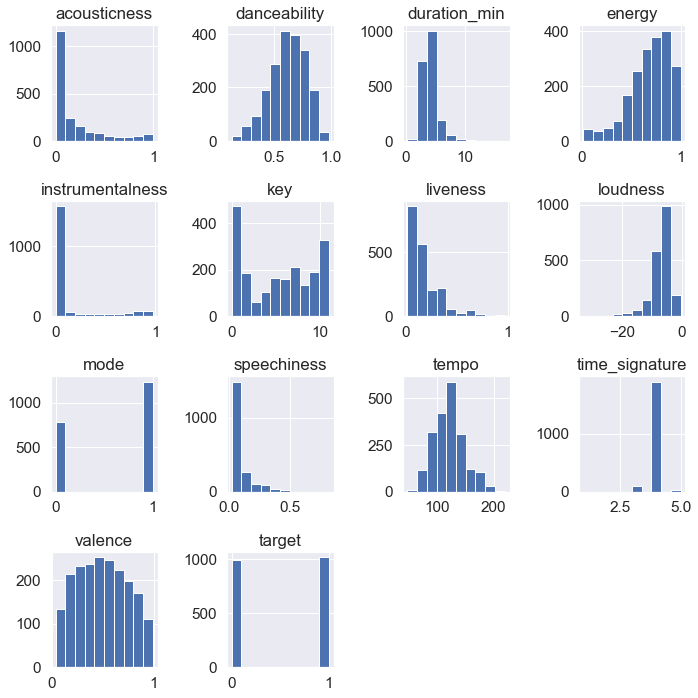

In [770]:
datos.hist(figsize=(10, 10)) 
plt.tight_layout()

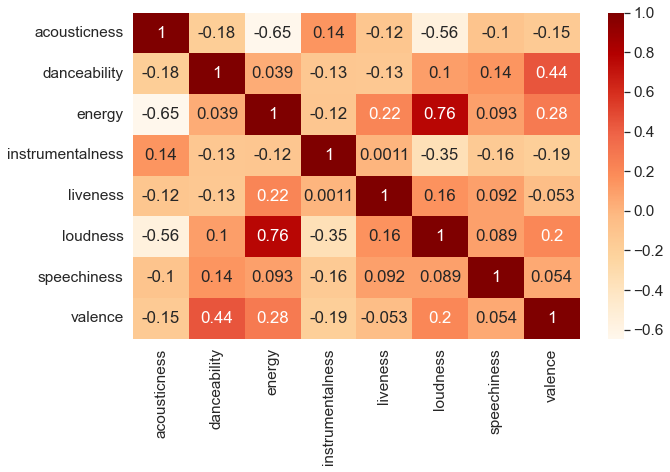

In [774]:
data_numerical=datos[['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','valence']]
plt.figure(figsize=(10,6))
sns.heatmap(data_numerical.corr(),annot=True,cmap='OrRd')
plt.show()

<AxesSubplot:>

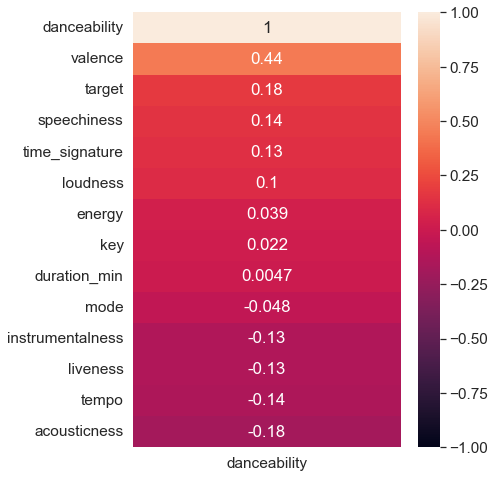

In [775]:
plt.figure(figsize=(6, 8)) 
tempdf = datos.corr()[['danceability']].sort_values('danceability', ascending=False).iloc[:20, :] 
sns.heatmap(tempdf, annot=True, vmin=-1, vmax=1)

In [773]:
# Normalización
ss = preprocessing.StandardScaler()
#datos_norm = datos.copy()
scale_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence']
datos[scale_features]=ss.fit_transform(datos[scale_features])
#datos_norm[scale_features]=ss.fit_transform(datos_norm[scale_features])

In [692]:
datos.head()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
1419,-0.687276,-1.145556,5.543333,0.491972,-0.488057,4,-0.378626,0.775543,0,0.393016,106.926,5.0,-0.420076,0
177,-0.306204,1.152737,5.602667,0.125691,-0.255170,10,-0.888231,0.528252,0,-0.592423,141.996,4.0,1.898503,1
35,-0.557046,0.301748,3.844883,-0.478436,-0.488057,0,-0.050472,0.510968,0,2.561872,110.953,4.0,-0.505050,1
222,0.828740,1.071987,3.332883,-0.083613,-0.488057,7,2.697018,0.364987,1,-0.106377,149.939,4.0,1.874225,1
185,-0.672849,-0.443645,4.088217,-0.221563,-0.488038,2,-0.851555,0.403277,1,0.493117,113.678,4.0,-0.003298,1


In [693]:
datos.describe()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2.017000e+03,2.017000e+03,2017.000000,2.017000e+03,2.017000e+03,2017.000000,2.017000e+03,2.017000e+03,2017.000000,2.017000e+03,2017.000000,2017.000000,2.017000e+03,2017.000000
mean,4.048433e-17,4.476120e-16,4.105103,1.433878e-17,-1.252235e-17,5.342588,-4.597490e-17,2.656939e-16,0.612295,5.963940e-17,121.603272,3.968270,-1.426722e-16,0.505702
std,1.000248e+00,1.000248e+00,1.366364,1.000248e+00,1.000248e+00,3.648240,1.000248e+00,1.000248e+00,0.487347,1.000248e+00,26.685604,0.255853,1.000248e+00,0.500091
min,-7.216979e-01,-3.083576e+00,0.267367,-3.171793e+00,-4.880565e-01,0.000000,-1.107000e+00,-6.916536e+00,0.000000,-7.737170e-01,47.859000,1.000000,-1.869491e+00,0.000000
25%,-6.846597e-01,-6.486275e-01,3.333583,-5.640598e-01,-4.880565e-01,2.000000,-6.340718e-01,-3.479027e-01,0.000000,-6.135554e-01,100.189000,4.000000,-8.166212e-01,0.000000
50%,-4.781769e-01,7.813008e-02,3.821017,1.589892e-01,-4.877775e-01,6.000000,-4.107981e-01,2.227279e-01,1.000000,-4.200267e-01,121.427000,4.000000,-1.948343e-02,1.000000
75%,2.978168e-01,7.427716e-01,4.505550,7.821433e-01,-2.903227e-01,9.000000,3.613301e-01,6.221161e-01,1.000000,1.705693e-01,137.849000,4.000000,7.857471e-01,1.000000
max,3.106321e+00,2.270826e+00,16.743783,1.505192e+00,3.085799e+00,11.000000,5.006968e+00,1.802465e+00,1.000000,8.045183e+00,219.331000,5.000000,2.003709e+00,1.000000


Arriba vemos que las columnas que hemos indicado que se normalicen tiene media 0 y varianza 1, como queríamos.

In [694]:
#Bucketizacion duration_min
bins = np.arange(0.00, 17.00, 2.0) 
datos['duration_min'] = pd.cut(datos.duration_min, bins, labels=bins[:-1])

In [695]:
#Bucketizacion tempo
bins = np.arange(46.00, 220.00, 25.0) 
datos['tempo'] = pd.cut(datos.tempo, bins, labels=bins[:-1])

In [696]:
datos.describe()

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,time_signature,valence,target
count,2.017000e+03,2.017000e+03,2.017000e+03,2.017000e+03,2017.000000,2.017000e+03,2.017000e+03,2017.000000,2.017000e+03,2017.000000,2.017000e+03,2017.000000
mean,4.048433e-17,4.476120e-16,1.433878e-17,-1.252235e-17,5.342588,-4.597490e-17,2.656939e-16,0.612295,5.963940e-17,3.968270,-1.426722e-16,0.505702
std,1.000248e+00,1.000248e+00,1.000248e+00,1.000248e+00,3.648240,1.000248e+00,1.000248e+00,0.487347,1.000248e+00,0.255853,1.000248e+00,0.500091
min,-7.216979e-01,-3.083576e+00,-3.171793e+00,-4.880565e-01,0.000000,-1.107000e+00,-6.916536e+00,0.000000,-7.737170e-01,1.000000,-1.869491e+00,0.000000
25%,-6.846597e-01,-6.486275e-01,-5.640598e-01,-4.880565e-01,2.000000,-6.340718e-01,-3.479027e-01,0.000000,-6.135554e-01,4.000000,-8.166212e-01,0.000000
50%,-4.781769e-01,7.813008e-02,1.589892e-01,-4.877775e-01,6.000000,-4.107981e-01,2.227279e-01,1.000000,-4.200267e-01,4.000000,-1.948343e-02,1.000000
75%,2.978168e-01,7.427716e-01,7.821433e-01,-2.903227e-01,9.000000,3.613301e-01,6.221161e-01,1.000000,1.705693e-01,4.000000,7.857471e-01,1.000000
max,3.106321e+00,2.270826e+00,1.505192e+00,3.085799e+00,11.000000,5.006968e+00,1.802465e+00,1.000000,8.045183e+00,5.000000,2.003709e+00,1.000000


In [697]:
datos['duration_min']

C:\Users\anama\anaconda3\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


1419    4.0
177     4.0
35      2.0
222     2.0
185     4.0
       ... 
1725    4.0
1767    4.0
1805    2.0
813     2.0
1085    2.0
Name: duration_min, Length: 2017, dtype: category
Categories (8, float64): [0.0 < 2.0 < 4.0 < 6.0 < 8.0 < 10.0 < 12.0 < 14.0]

In [698]:
datos['tempo']

1419     96.0
177     121.0
35       96.0
222     146.0
185      96.0
        ...  
1725     96.0
1767    121.0
1805    121.0
813      96.0
1085     96.0
Name: tempo, Length: 2017, dtype: category
Categories (6, float64): [46.0 < 71.0 < 96.0 < 121.0 < 146.0 < 171.0]

In [699]:
bucketized_features = ['duration_min', 'tempo']
datos_cat = pd.get_dummies(datos[bucketized_features])
datos = datos.drop(bucketized_features, axis=1)
datos = pd.concat([datos, datos_cat], axis=1)

In [700]:
# Separamos el dataset en X y labels(y). Pasamos de pandas a numpy para seguir operando con arrays de numpy.
X = datos.iloc[:, 0:13].to_numpy()
y = datos.iloc[:, 13].to_numpy()

In [701]:
print(X.shape)
print(y.shape)

(2017, 13)
(2017,)


## 3. Dataset final

Explicar el dataset que obtenemos tras el preprocesamiento. Tipo:
Tras las operaciones de preprocesamiento que hemos detallado en el apartado anterior. hemos obtenido un dataset final con el que vamos a trabajar que consiste en 2017 ejemplos de entrenamiento y 13 columnas, es decir, atributos. 

## 4. Separación en entrenamiento, validación y test

Dividimos el dataset en entrenamiento, validación y test. 

Hacemos una división en las siguientes partes:
- **60%** Entrenamiento (training set)
- **20%** Validación (validation set)
- **20%** test (test set)

In [702]:
x, x_test, y, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.25,train_size =0.75)

In [703]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
#La entrada 13 neuronas porque en la p4 5000 ejemplos de entrenamiento y cada uno tenía 400 componentes 
#y la red neuronal tenía 400 neuronas de entradas (parece que el numero de atributos)
#La capa intermedia tiene limitación?????? Normalmente suele ser (formulita) por ejemplo el doble que de entrada, en este caso 26
#La ultima capa tiene 2 neuronas de salida porque tenemos 2 labels (0 y 1)

(1209, 13)
(404, 13)
(404, 13)


## 4. Regresión logística

In [704]:
from sklearn.preprocessing import PolynomialFeatures
import scipy.optimize as opt

### 4.1 Regresión logística lineal

In [705]:
def sigmoide(z):
    return (1.0/(1.0+np.exp(-z)))

In [706]:
def coste(Theta, X, y):
    H = sigmoide(np.dot(X, Theta))
    Term1 = np.matmul(y, np.log(H))
    Term2 = np.matmul((1 - y), np.log(1 - H))
    cost = (- 1 / (len(y))) * np.sum(Term1 + Term2)
    return cost

In [707]:
def coste_reg(Theta, X, y, Lambda):
    Term1 = coste(Theta, X, y)
    Term2 = (Lambda/(2*len(y))) * np.sum(Theta**2)
    cost = Term1 + Term2
    return cost 

In [708]:
def gradiente(Theta, X, y):
    H = sigmoide(np.dot(X, Theta))
    Dif = H - y
    grad = (1 / len(y)) * np.matmul(Dif, X)
    return grad

In [709]:
def gradiente_reg(Theta, X, y, Lambda):
    grad = gradiente(Theta, X, y) + ((Lambda/len(y))*np.r_[[0],Theta[1:]])
    return grad

In [710]:
def evaluacion(theta, X, Y):
    prediccion = sigmoide(np.matmul(theta, np.transpose(X)))
    prediccion[prediccion >= 0.5] = 1
    prediccion[prediccion < 0.5] = 0
    porcentaje = np.asarray(np.where(prediccion == Y)).size
    return  (porcentaje / len(Y))*100

In [711]:
#Optimizacion de Theta con Lambda = 1
x_train_1 = np.hstack([np.ones([len(x_train), 1]), x_train])
Theta = np.zeros(x_train_1.shape[1])
Lambda = 1
result = opt.fmin_tnc(func=coste_reg, x0=Theta, fprime=gradiente_reg, args=(x_train_1,y_train,Lambda))
Theta_opt=result[0]
print(Theta_opt)
coste_opt = coste_reg(Theta_opt, x_train_1, y_train, Lambda)
print('Coste regularizado (entrenamiento) = {}'.format(coste_opt))
error = coste(Theta_opt, x_train_1, y_train)
print('Error - coste (entrenamiento) = {}'.format(error))

[-0.34687616  0.16947049 -0.06016025 -0.07392198 -0.3097021  -0.03205097
 -0.05529716  0.43453569  0.14865607  0.13775491  0.2480237   0.16154873
 -0.44864178 -2.11054433]
Coste regularizado (entrenamiento) = 0.6262016326527708
Error - coste (entrenamiento) = 0.6240381445075122


In [712]:
porcentaje_aciertos_train = evaluacion(Theta_opt, x_train_1, y_train)
print("El porcentaje de ejemplos de entrenamientos que se clasifican correctamente es: {}%".format(porcentaje_aciertos_train))
x_val_1 = np.hstack([np.ones([len(x_val), 1]), x_val])
porcentaje_aciertos_val = evaluacion(Theta_opt, x_val_1, y_val)
print("El porcentaje de ejemplos de validacion que se clasifican correctamente es: {}%".format(porcentaje_aciertos_val))

El porcentaje de ejemplos de entrenamientos que se clasifican correctamente es: 66.25310173697271%
El porcentaje de ejemplos de validacion que se clasifican correctamente es: 67.82178217821783%


In [713]:
lambdas = [150, 100, 50, 10, 1, 0.5, 0.25]
bestScore= -1
acc_train =[]
acc_val = []
tiempo_inicial = time()
for i in lambdas:
    result = opt.fmin_tnc(func=coste_reg, x0=Theta, fprime=gradiente_reg, args=(x_train_1,y_train,i))
    Theta_opt=result[0]
    porcentaje_aciertos_train = evaluacion(Theta_opt, x_train_1, y_train)
    acc_train.append(porcentaje_aciertos_train)
    porcentaje_aciertos_val = evaluacion(Theta_opt, x_val_1, y_val)
    acc_val.append(porcentaje_aciertos_val)
    if(porcentaje_aciertos_val > bestScore):
            bestScore = porcentaje_aciertos_val
            bestLambda = i
            bestThetaOpt = Theta_opt

    print("Lambda {} Train - {}%, Validation - {}%".format(i, porcentaje_aciertos_train,porcentaje_aciertos_val))
print("Best Lambda:{}, best porcentaje aciertos validacion:{}%".format(bestLambda, bestScore))

tiempo_final =  time()
tiempo_logistic_linear = tiempo_final - tiempo_inicial
print("Tiempo entrenamiento regresión logística lineal: {} segundos".format(tiempo_logistic_linear))

Lambda 150 Train - 64.35070306038048%, Validation - 66.0891089108911%
Lambda 100 Train - 64.92969396195203%, Validation - 66.33663366336634%
Lambda 50 Train - 65.34325889164599%, Validation - 66.58415841584159%
Lambda 10 Train - 66.33581472291151%, Validation - 66.58415841584159%
Lambda 1 Train - 66.25310173697271%, Validation - 67.82178217821783%
Lambda 0.5 Train - 66.25310173697271%, Validation - 67.57425742574257%
Lambda 0.25 Train - 66.17038875103391%, Validation - 67.57425742574257%
Best Lambda:1, best porcentaje aciertos validacion:67.82178217821783%
Tiempo entrenamiento regresión logística lineal: 0.5187461376190186 segundos


In [714]:
x_test_1 = np.hstack([np.ones([len(x_test), 1]), x_test])
acc_test_Logistic_Linear = evaluacion(bestThetaOpt, x_test_1, y_test)
print("El porcentaje de ejemplos de test que se clasifican correctamente es: {}%".format(acc_test_Logistic_Linear))

El porcentaje de ejemplos de test que se clasifican correctamente es: 70.04950495049505%


In [715]:
def plot_results(vector_x, acc_train, acc_val, bestLambda, porcentaje_aciertos_test):
    plt.plot(vector_x, acc_train, label='Training')
    plt.plot(vector_x, acc_val, label='Validation')
    plt.scatter(bestLambda, porcentaje_aciertos_test, label= 'Accuracy test')

    plt.xlabel('Lambdas')
    plt.ylabel('Accuracy')
    plt.title('Regresión Logística')
    plt.legend(loc = 'best', bbox_to_anchor=(1,1))
    plt.show()

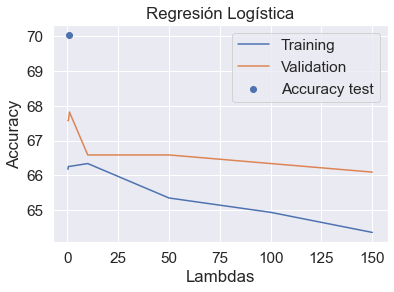

In [716]:
plot_results(lambdas, acc_train, acc_val, bestLambda, acc_test_Logistic_Linear)

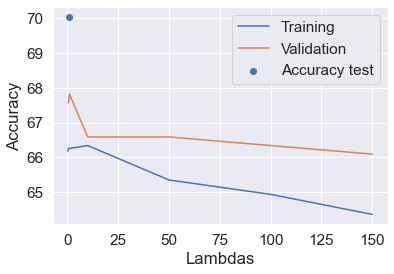

In [717]:
plt.plot(lambdas, acc_train, label='Training')
plt.plot(lambdas, acc_val, label='Validation')
plt.scatter(bestLambda, acc_test_Logistic_Linear, label= 'Accuracy test')

plt.xlabel('Lambdas')
plt.ylabel('Accuracy')
plt.legend(loc = 'best', bbox_to_anchor=(1,1))
plt.show()

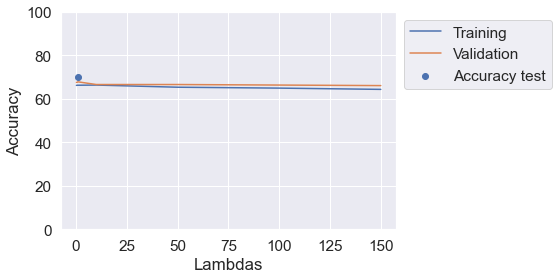

In [718]:
plt.plot(lambdas, acc_train, label='Training')
plt.plot(lambdas, acc_val, label='Validation')
plt.scatter(bestLambda, acc_test_Logistic_Linear, label= 'Accuracy test')
plt.ylim(0, 100)

plt.xlabel('Lambdas')
plt.ylabel('Accuracy')
plt.legend(loc = 'best', bbox_to_anchor=(1,1))
plt.show()

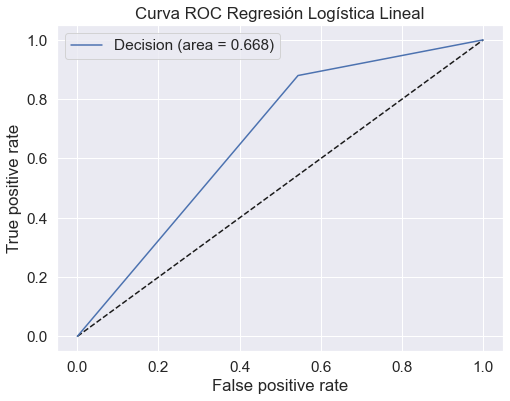

In [719]:
y_pred= sigmoide(np.matmul(bestThetaOpt, np.transpose(x_test_1)))
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0


fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Decision (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Curva ROC Regresión Logística Lineal')
plt.legend(loc='best')
plt.show()

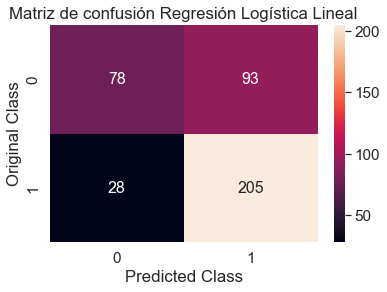

In [720]:
plt.figure(figsize=(6,4))
df_ = pd.DataFrame(confusion_matrix(y_test,y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title('Matriz de confusión Regresión Logística Lineal')
plt.show()

### 4.2 Regresión logística polinomial

In [721]:
poly = PolynomialFeatures(6)
XX_train = poly.fit_transform(x_train)

In [722]:
Theta = np.zeros(XX_train.shape[1])
Lambda = 1
c = coste_reg(Theta, XX_train, y_train, Lambda)
grad = gradiente_reg(Theta, XX_train, y_train, Lambda)
print('Coste = {}'.format(c))
print('Gradiente = {}'.format(grad))

Coste = 0.6931471805599453
Gradiente = [-0.07485525  0.01290854 -0.01650939 ...  0.00289495  0.00289495
  0.00496278]


In [723]:
#Optimizacion de Theta con Lambda = 1
result = opt.fmin_tnc(func=coste_reg, x0=Theta, fprime=gradiente_reg, args=(XX_train,y_train,Lambda))
Theta_opt=result[0]
print(Theta_opt)
coste_opt = coste_reg(Theta_opt, XX_train, y_train, Lambda)
print('Coste regularizado (entrenamiento) = {}'.format(coste_opt))
error = coste(Theta_opt, XX_train, y_train)
print('Error - coste (entrenamiento) = {}'.format(error))

C:\Users\anama\AppData\Local\Temp/ipykernel_18716/4140217642.py:4: RuntimeWarning: divide by zero encountered in log
  Term2 = np.matmul((1 - y), np.log(1 - H))
C:\Users\anama\AppData\Local\Temp/ipykernel_18716/4140217642.py:4: RuntimeWarning: invalid value encountered in matmul
  Term2 = np.matmul((1 - y), np.log(1 - H))


[ 2.87533302e-06  1.73887583e-06  5.16930448e-07 ... -4.29386272e-07
 -4.29386272e-07 -7.17802130e-07]
Coste regularizado (entrenamiento) = 0.46469675298208807
Error - coste (entrenamiento) = 0.46469674492746516


In [724]:
porcentaje_aciertos_train = evaluacion(Theta_opt, XX_train, y_train)
print("El porcentaje de ejemplos de entrenamientos que se clasifican correctamente es: {}%".format(porcentaje_aciertos_train))

El porcentaje de ejemplos de entrenamientos que se clasifican correctamente es: 77.75020678246484%


In [725]:
poly = PolynomialFeatures(6)
XX_val = poly.fit_transform(x_val)
porcentaje_aciertos_val = evaluacion(Theta_opt, XX_val, y_val)
print("El porcentaje de ejemplos de validacion que se clasifican correctamente es: {}%".format(porcentaje_aciertos_val))

El porcentaje de ejemplos de validacion que se clasifican correctamente es: 59.65346534653465%


In [726]:
lambdas = [150, 100, 50, 10, 1, 0.5, 0.25]
Theta = np.zeros(XX_train.shape[1])
bestScore= -1
acc_train =[]
acc_val = []
tiempo_inicial = time()
for i in lambdas:
    result = opt.fmin_tnc(func=coste_reg, x0=Theta, fprime=gradiente_reg, args=(XX_train,y_train,i))
    Theta_opt=result[0]
    porcentaje_aciertos_train = evaluacion(Theta_opt, XX_train, y_train)
    acc_train.append(porcentaje_aciertos_train)
    porcentaje_aciertos_val = evaluacion(Theta_opt, XX_val, y_val)
    acc_val.append(porcentaje_aciertos_val)
    if(porcentaje_aciertos_val > bestScore):
            bestScore = porcentaje_aciertos_val
            bestLambda = i
            bestThetaOpt = Theta_opt
 
    print("Lambda {} Train - {}%, Validation - {}%".format(i, porcentaje_aciertos_train,porcentaje_aciertos_val))
print("Best Lambda:{}, best porcentaje aciertos validacion:{}%".format(bestLambda, bestScore))
tiempo_final =  time()
tiempo_logistic_poly = tiempo_final - tiempo_inicial
print("Tiempo entrenamiento regresión logística polinomial: {} segundos".format(tiempo_logistic_poly))

C:\Users\anama\AppData\Local\Temp/ipykernel_18716/4140217642.py:4: RuntimeWarning: divide by zero encountered in log
  Term2 = np.matmul((1 - y), np.log(1 - H))
C:\Users\anama\AppData\Local\Temp/ipykernel_18716/4140217642.py:4: RuntimeWarning: invalid value encountered in matmul
  Term2 = np.matmul((1 - y), np.log(1 - H))


Lambda 150 Train - 77.75020678246484%, Validation - 59.65346534653465%
Lambda 100 Train - 77.75020678246484%, Validation - 59.65346534653465%
Lambda 50 Train - 77.75020678246484%, Validation - 59.65346534653465%
Lambda 10 Train - 77.75020678246484%, Validation - 59.65346534653465%
Lambda 1 Train - 77.75020678246484%, Validation - 59.65346534653465%
Lambda 0.5 Train - 77.75020678246484%, Validation - 59.65346534653465%
Lambda 0.25 Train - 84.69809760132341%, Validation - 60.148514851485146%
Best Lambda:0.25, best porcentaje aciertos validacion:60.148514851485146%
Tiempo entrenamiento regresión logística polinomial: 109.15310311317444 segundos


In [727]:
poly = PolynomialFeatures(6)
XX_test = poly.fit_transform(x_test)
acc_test_Logistic_poly = evaluacion(bestThetaOpt, XX_test, y_test)
print("El porcentaje de ejemplos de test que se clasifican correctamente es: {}%".format(acc_test_Logistic_poly))

El porcentaje de ejemplos de test que se clasifican correctamente es: 63.11881188118812%


In [728]:
y_predicc = sigmoide(np.matmul(bestThetaOpt, np.transpose(XX_test)))
y_predicc[y_predicc >= 0.5] = 1
y_predicc[y_predicc < 0.5] = 0
accuracy_test = accuracy_score(y_test, y_predicc)
print("Accuracy test Regresión Logística: {}".format(accuracy_test*100))

Accuracy test Regresión Logística: 63.11881188118812


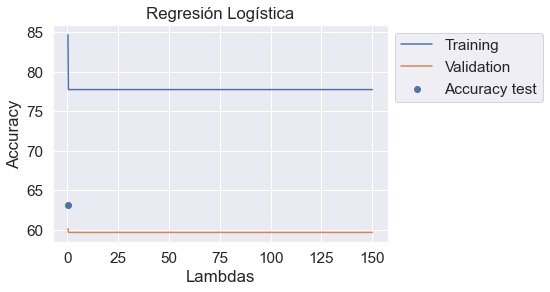

In [729]:
plot_results(lambdas, acc_train, acc_val, bestLambda, acc_test_Logistic_poly)

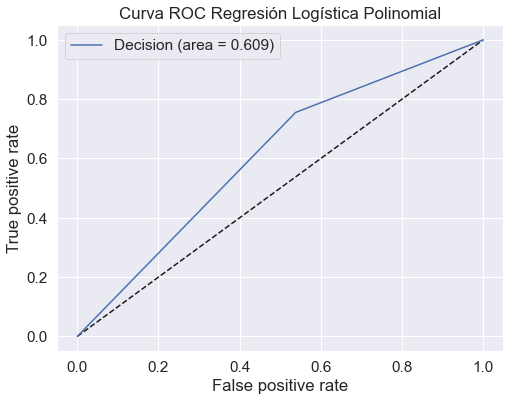

In [730]:
y_pred= sigmoide(np.matmul(bestThetaOpt, np.transpose(XX_test)))
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Decision (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Curva ROC Regresión Logística Polinomial')
plt.legend(loc='best')
plt.show()

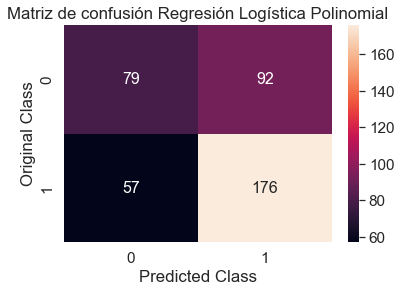

In [731]:
plt.figure(figsize=(6,4))
df_ = pd.DataFrame(confusion_matrix(y_test,y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title('Matriz de confusión Regresión Logística Polinomial')
plt.show()

Graficar los porcentajes de acierto de train, val y test para cada valor de Lambda (eje x lambda, eje y porcentaje aciertos, 3 curvas: train, val y test)
Medir tiempos
Medir la precision (accuracy, precision, recall, F1, classification_report, plot_confussion_matrix, ROC curve)

## 5. Redes neuronales

In [732]:
def forwardprop(X, theta1, theta2):
    X_1 = np.hstack([np.ones([len(X), 1]), X])
    a_1 = X_1
    z_2 = np.matmul(a_1, theta1.T)
    a_2 = sigmoide(z_2)
    a_2 = np.hstack([np.ones([len(a_2), 1]), a_2])
    z_3 = np.matmul(a_2, theta2.T)
    a_3 = sigmoide(z_3)
    return a_1, z_2, a_2, z_3, a_3

In [733]:
def coste_NN(H, y, m):
    Term1 = y * np.log(H) 
    Term2 =  (1 - y) * np.log(1 - H)
    cost = ( 1 / m) * np.sum(-Term1 - Term2)
    return cost

In [734]:
def coste_reg_NN(theta1, theta2, coste, lamb, m):
    reg = (np.sum(np.power(theta1[:, 1:], 2)) + np.sum(np.power(theta2[:, 1:], 2))) 
    coste_reg = coste + (reg* (lamb/(2*m)))
    return coste_reg

In [735]:
def func_g(z):
    ones = np.ones(z.shape)
    a = sigmoide(z)
    return a*(ones-a)

In [736]:
def yOneHot(y, num_etiquetas):
    m = len(y)
    y_onehot = np.zeros((m, num_etiquetas)) #Matriz 5000 x 10
    for i in range(m):
        y_onehot[i][y[i]] = 1
    return y_onehot

In [737]:
def backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg):
    Theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)],(num_ocultas, (num_entradas + 1)))
    Theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):],(num_etiquetas, (num_ocultas + 1)))
    
    #Forward propagation
    a1, z2, a2, z3, a3 = forwardprop(X, Theta1, Theta2)
    
    #Backward propagation
    sigma_3 = np.array(a3 - y)
    sigma_2 = np.matmul(Theta2.T[1:, :], sigma_3.T) * func_g(z2).T
    
    delta_1 = np.zeros(Theta1.shape)
    delta_2 = np.zeros(Theta2.shape)
    
    delta_1 = delta_1 + np.matmul(sigma_2, a1)
    delta_2 = delta_2 + np.matmul(sigma_3.T, a2)
    
    grad_1 = (1/len(y))*(delta_1) + (reg/len(y))*np.r_[[np.zeros(Theta1.shape[1])],Theta1[1:]]
    grad_2 = (1/len(y))*(delta_2) + (reg/len(y))*np.r_[[np.zeros(Theta2.shape[1])],Theta2[1:]]
    
    gradiente = np.concatenate((grad_1, grad_2), axis = None)
    
    cost = coste_NN(a3, y, len(y))
    
    return cost, gradiente

In [738]:
def inicializacionPesos(L_in, L_out):
    c_ini = 0.12
    peso = np.random.uniform(-c_ini, c_ini, size = (L_in, L_out))
    peso = np.insert(peso,0,1,axis = 0)
    return peso

In [739]:
def evaluacion_NN(Y, h):
    predicciones = h.argmax(axis = 1)
    
    comparacion = (predicciones == Y)*1

    precision = (sum(comparacion) / len(comparacion))*100
    
    return precision

In [740]:
def aprendizaje(num_entradas, num_ocultas, num_etiquetas, X, Y, reg, it):
    theta1 = inicializacionPesos(num_entradas, num_ocultas)
    theta2 = inicializacionPesos(num_ocultas, num_etiquetas)
    
    y_OneHot=yOneHot(Y,2)
    
    params = np.hstack((np.ravel(theta1), np.ravel(theta2)))
    result = opt.minimize(fun = backprop, x0 = params, args = (num_entradas, num_ocultas, num_etiquetas, X, y_OneHot, reg), method='TNC', jac = True, options = {'maxiter': it})

    Thetas1 = result.x[:(num_ocultas*(num_entradas+1))].reshape(num_ocultas,(num_entradas+1))
    Thetas2 = result.x[(num_ocultas*(num_entradas+1)):].reshape(num_etiquetas,(num_ocultas+1))

    h = forwardprop(X, Thetas1, Thetas2)[4]
    precision = evaluacion_NN(Y,h)
    
    return Thetas1, Thetas2, precision

In [741]:
#x_train1 = np.hstack([np.ones([len(y_train), 1]), x_train])
Thetas1, Thetas2, precision=aprendizaje(13,26,2,x_train,y_train,1, 100)
print('La precisión es {} % '.format(precision))

La precisión es 67.65922249793218 % 


In [742]:
reg_vec = [1, 1.5, 2, 3, 5, 10, 15, 30]
it_vec = [70, 100, 150, 200, 300, 400, 500]
scores = np.zeros((len(reg_vec), len(it_vec)))

acc_train =[]
acc_val = []

bestReg = 0.01
bestIt = 0.01
bestScore = -1

tiempo_inicial = time()

for r in reg_vec:
    for it in it_vec:
        Thetas1, Thetas2, score_train = aprendizaje(13,26,2,x_train,y_train,r,it)
        acc_train.append(score_train)
        h = forwardprop(x_val, Thetas1, Thetas2)[4]
        score_val = evaluacion_NN(y_val,h)
        acc_val.append(score_val)
        if(score_val > bestScore):
            bestReg = r
            bestIt = it
            bestScore = score_val
            bestThetas1 = Thetas1
            bestThetas2= Thetas2
        #print("Reg {}, it {}: Train - {}%, Validation - {}%".format(r,it, score_train,score_val))

tiempo_final =  time()
tiempo_NN = tiempo_final - tiempo_inicial

print("Best score: ", bestScore)
print("Best iterations: ", bestIt)
print("Best Reg parameter:", bestReg)
print("Best reg:{}, it {}: best porcentaje aciertos validacion:{}%".format(bestReg, bestIt, bestScore))

print("Tiempo entrenamiento Red Neuronal: {} segundos".format(tiempo_NN))
        

Best score:  67.57425742574257
Best iterations:  150
Best Reg parameter: 15
Best reg:15, it 150: best porcentaje aciertos validacion:67.57425742574257%
Tiempo entrenamiento Red Neuronal: 164.90818810462952 segundos


In [743]:
#TEST
h = forwardprop(x_test, bestThetas1, bestThetas2)[4]
acc_test_NN = evaluacion_NN(y_test,h)
print('La precisión del test es {} % '.format(acc_test_NN))

La precisión del test es 66.83168316831683 % 


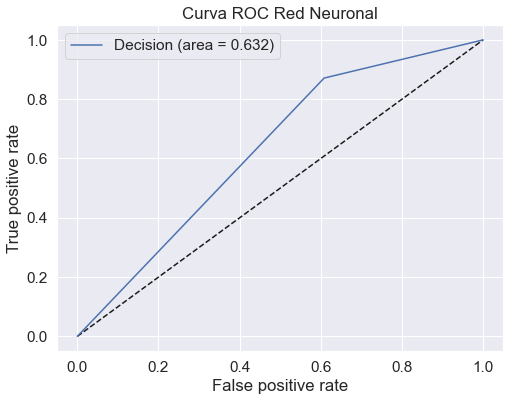

In [744]:
y_pred = h.argmax(axis = 1)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Decision (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Curva ROC Red Neuronal')
plt.legend(loc='best')
plt.show()

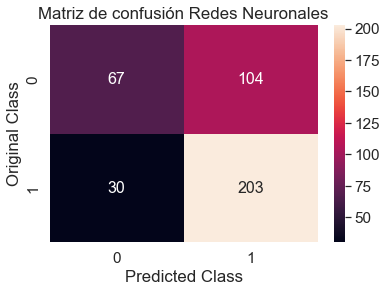

In [745]:
plt.figure(figsize=(6,4))
df_ = pd.DataFrame(confusion_matrix(y_test,y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title('Matriz de confusión Redes Neuronales')
plt.show()

In [746]:
#plot_results(reg_vec, acc_train, acc_val, bestReg, score_test)

## 6. Support Vector Machine

In [747]:
C_vec = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
sigma_vec = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
scores = np.zeros((len(C_vec), len(sigma_vec)))

acc_train =[]
acc_val = []

bestC = 0.01
bestSigma = 0.01
bestScore = -1

tiempo_inicial = time()

for c in C_vec:
    for sigma in sigma_vec:
        gamma = 1/(2*sigma **2)
        aux_kernel = SVC(C = c, kernel = 'rbf', gamma = gamma)
        aux_kernel.fit(x_train, y_train.ravel())
        score_train =  aux_kernel.score(x_train, y_train)
        acc_train.append(score_train)
        score = aux_kernel.score(x_val, y_val)
        acc_val.append(score)
        if(score > bestScore):
            bestC = c
            bestSigma = sigma
            bestScore = score

tiempo_final =  time()
tiempo_SVM = tiempo_final - tiempo_inicial
print("Best score: ", bestScore)
print("Best sigma: ", bestSigma)
print("Best C:", bestC)
print("Tiempo entrenamiento SVM: {} segundos".format(tiempo_SVM))


Best score:  0.6608910891089109
Best sigma:  10
Best C: 30
Tiempo entrenamiento SVM: 76.25012874603271 segundos


In [748]:
gamma = 1/(2*bestSigma **2)
aux_kernel = SVC(C = bestC, kernel = 'rbf', gamma = gamma)
aux_kernel.fit(x_train, y_train.ravel())
acc_test_SVM =  aux_kernel.score(x_test, y_test)*100
print('La precisión del test es {} % '.format(acc_test_SVM))

La precisión del test es 65.34653465346535 % 


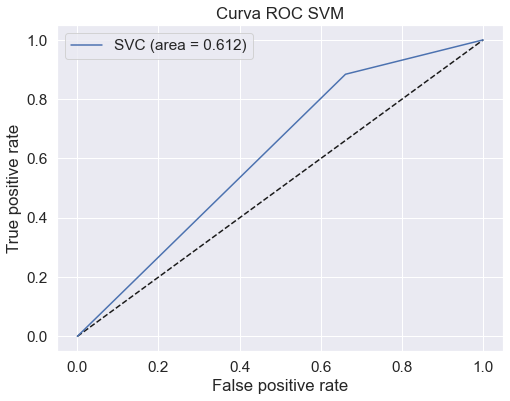

In [749]:
y_pred= aux_kernel.predict(x_test).ravel()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='SVC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Curva ROC SVM')
plt.legend(loc='best')
plt.show()

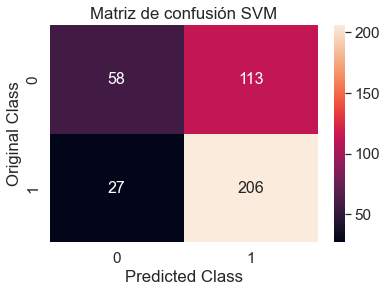

In [750]:
plt.figure(figsize=(6,4))
df_ = pd.DataFrame(confusion_matrix(y_test,y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title('Matriz de confusión SVM')
plt.show()

In [751]:
#plot_results(C_vec, acc_train, acc_val, bestC, score_test)

## 7. Comparación

Estudio con crossvalidation (diapositivas kfold cross validation)
Curvas ROC

In [752]:
models = pd.DataFrame({
    'Model': ['Regresión Logística Lineal','Regresión Logística Polinomial', 'Redes neuronales',  'SVM'],
    'Score': [ acc_test_Logistic_Linear,acc_test_Logistic_poly, acc_test_NN, acc_test_SVM],  
    'seconds': [tiempo_logistic_linear,tiempo_logistic_poly, tiempo_NN, tiempo_SVM]
})

models.sort_values(by = 'Score', ascending = False)

,Model,Score,seconds
0,Regresión Logística Lineal,70.049505,0.518746
2,Redes neuronales,66.831683,164.908188
3,SVM,65.346535,76.250129
1,Regresión Logística Polinomial,63.118812,109.153103


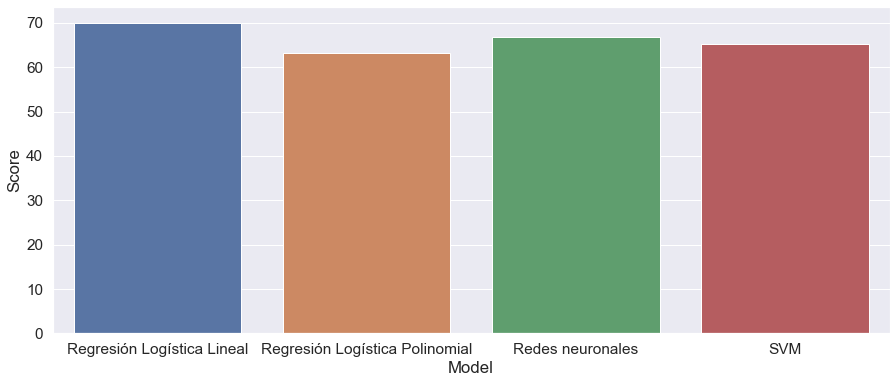

In [753]:
plt.figure(figsize=(15,6))
sns.barplot(x='Model',y='Score',data=models)
plt.show()

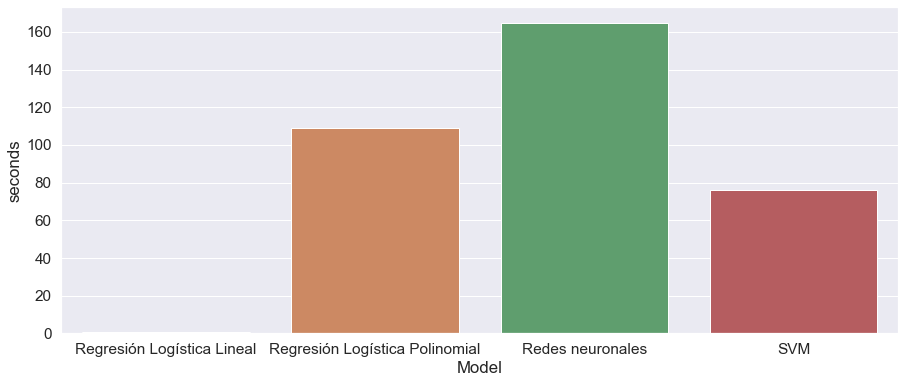

In [754]:
plt.figure(figsize=(15,6))
sns.barplot(x='Model',y='seconds',data=models)
plt.show()

## 8. Conclusiones